In [1]:
%tensorflow_version 1.15
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 800
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

hyper_parameter = [(50,50), (50,70), (50,80), (50,90), (70,70), (70,80), 
                   (70,90), (80,80), (80, 90), (90,90)]

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10924369317817786162, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13171300902367345431
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11528992100898728622
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 403469341756596166
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
def load_data(file):
  with open(file, 'rb') as fo:
      try:
          samples = pickle.load(fo)
      except UnicodeDecodeError:  # python 3.x
          fo.seek(0)
          samples = pickle.load(fo, encoding='latin1')

  data, labels = samples['data'], samples['labels']

  data = np.array(data, dtype=np.float32)
  labels = np.array(labels, dtype=np.int32)

  labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
  labels_[np.arange(labels.shape[0]), labels - 1] = 1

  return data, labels_

def cnn_2(images, no_map1, no_map2):
  images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

  # Conv 1
  W_conv1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, no_map1], stddev=1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)),
                   name='weights_1')
  b_conv1 = tf.Variable(tf.zeros([no_map1]), name='biases_1')

  h_conv_1 = tf.nn.relu(tf.nn.conv2d(images, W_conv1, [1, 1, 1, 1], padding='VALID') + b_conv1)
  h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_1')

  # Conv 2
  W_conv2 = tf.Variable(tf.truncated_normal([5, 5, no_map1, no_map2], stddev=1.0 / np.sqrt(no_map1 * 5 * 5)),
                   name='weights_2')
  b_conv2 = tf.Variable(tf.zeros([no_map2]), name='biases_2')

  h_conv_2 = tf.nn.relu(tf.nn.conv2d(h_pool_1, W_conv2, [1, 1, 1, 1], padding='VALID') + b_conv2)
  h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_2')

  
  dim = h_pool_2.get_shape()[1].value * h_pool_2.get_shape()[2].value * h_pool_2.get_shape()[3].value
  # FC 1
  W_fc_1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0 / np.sqrt(dim)),
                   name='weights_3')
  b_fc_1 = tf.Variable(tf.zeros([300]), name='biases_3')
  
  pool_2_flat = tf.reshape(h_pool_2, [-1, dim])
  h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc_1) + b_fc_1)
  
  # Softmax
  W_fc_2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0 / np.sqrt(300)), name='weights_4')
  b_fc_2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
  logits = tf.matmul(h_fc1, W_fc_2) + b_fc_2

  keep_prob = 1

  return W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob

def train(no_map1, no_map2):  
  trainX, trainY = load_data('./data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('./test_batch_trim')
  print(testX.shape, testY.shape)

  trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  with tf.device('/device:GPU:0'):

    # Create the model
    x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn_2(x, no_map1, no_map2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      test_acc = []
      train_cost = []

      for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
          train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        

        if e%100 == 0:
          print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e,train_cost[e], test_acc[e]))
          
  return train_cost, test_acc

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.2969746589660645, Test Acc = 0.10649999976158142
Epoch 100: Train Cost = 1.8580964803695679, Test Acc = 0.32350000739097595
Epoch 200: Train Cost = 1.7253779172897339, Test Acc = 0.33550000190734863
Epoch 300: Train Cost = 1.6277897357940674, Test Acc = 0.3555000126361847
Epoch 400: Train Cost = 1.5598618984222412, Test Acc = 0.3125
Epoch 500: Train Cost = 1.4175697565078735, Test Acc = 0.3644999861717224
Epoch 600: Train Cost = 1.3549158573150635, Test Acc = 0.3714999854564667
Epoch 700: Train Cost = 1.2912142276763916, Test Acc = 0.3634999990463257
(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.301755905151367, Test Acc = 0.1340000033378601
Epoch 100: Train Cost = 1.832411527633667, Test Acc = 0.33250001072883606
Epoch 200: Train Cost = 1.670668363571167, Test Acc = 0.37549999356269836
Epoch 300: Train Cost = 1.5533406734466553, Test Acc = 0.3479999899864197
Epoch 400: Train Cost = 1.

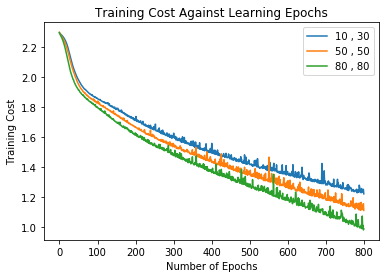

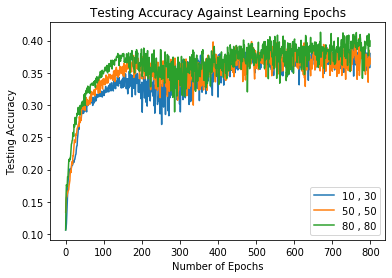

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

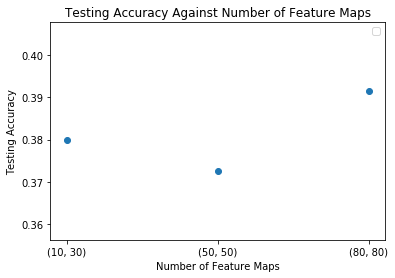

<Figure size 432x288 with 0 Axes>

In [0]:
hyper_parameter = [(10,30), (50,50), (80, 80)]
train_cost = []
test_acc = []
for h_para in hyper_parameter:
  train_result, test_result = train(h_para[0], h_para[1])
  train_cost.append(train_result)
  test_acc.append(test_result)

plt.figure(1)
for idx in range(len(train_cost)):
  plt.plot(range(epochs), train_cost[idx], label=str(hyper_parameter[idx][0])+" , " + str(hyper_parameter[idx][1]))
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Training Cost')
plt.title("Training Cost Against Learning Epochs")
plt.show()
plt.savefig('./q2_train_cost_1-1.png')

plt.figure(1)
for idx in range(len(test_acc)):
  plt.plot(range(epochs), test_acc[idx], label=str(hyper_parameter[idx][0])+" , " + str(hyper_parameter[idx][1]))
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Learning Epochs")
plt.show()
plt.savefig('./q2_test_acc_1-1.png')

plt.figure(2)

paras = [testing[-1] for testing in test_acc]

plt.scatter(range(len(hyper_parameter)), paras)
plt.xticks(range(len(hyper_parameter)), hyper_parameter)


plt.xlabel('Number of Feature Maps')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Number of Feature Maps")
plt.show()
plt.savefig('./q2_test_acc_1-2.png')

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.30285382270813, Test Acc = 0.10849999636411667
Epoch 100: Train Cost = 1.8252019882202148, Test Acc = 0.3370000123977661
Epoch 200: Train Cost = 1.6645888090133667, Test Acc = 0.36550000309944153
Epoch 300: Train Cost = 1.5327261686325073, Test Acc = 0.34950000047683716
Epoch 400: Train Cost = 1.436596393585205, Test Acc = 0.3190000057220459
Epoch 500: Train Cost = 1.3084287643432617, Test Acc = 0.3790000081062317
Epoch 600: Train Cost = 1.2302656173706055, Test Acc = 0.3889999985694885
Epoch 700: Train Cost = 1.1474324464797974, Test Acc = 0.3619999885559082
(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.2923989295959473, Test Acc = 0.14300000667572021
Epoch 100: Train Cost = 1.790523648262024, Test Acc = 0.3479999899864197
Epoch 200: Train Cost = 1.6097832918167114, Test Acc = 0.39750000834465027
Epoch 300: Train Cost = 1.4818249940872192, Test Acc = 0.35899999737739563
Epoch 400: Tra

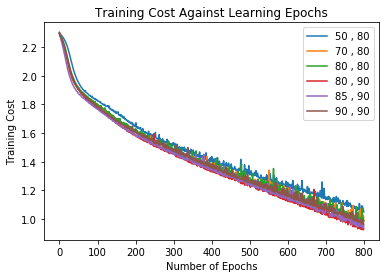

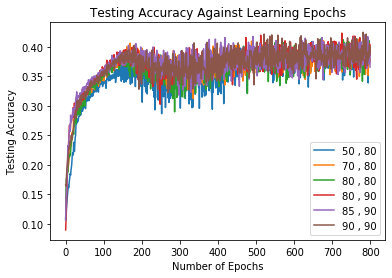

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

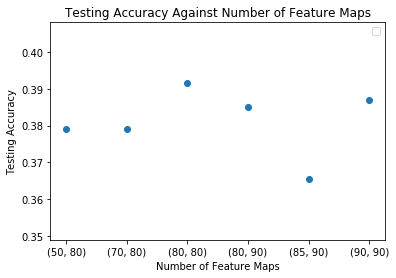

<Figure size 432x288 with 0 Axes>

In [4]:
hyper_parameter = [(50,80), (70,80), (80, 80),(80, 90), (85,90), (90,90)]
train_cost = []
test_acc = []
for h_para in hyper_parameter:
  train_result, test_result = train(h_para[0], h_para[1])
  train_cost.append(train_result)
  test_acc.append(test_result)

plt.figure(1)
for idx in range(len(train_cost)):
  plt.plot(range(epochs), train_cost[idx], label=str(hyper_parameter[idx][0])+" , " + str(hyper_parameter[idx][1]))
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Training Cost')
plt.title("Training Cost Against Learning Epochs")
plt.show()
plt.savefig('./2_train_cost_2-1.png')

plt.figure(1)
for idx in range(len(test_acc)):
  plt.plot(range(epochs), test_acc[idx], label=str(hyper_parameter[idx][0])+" , " + str(hyper_parameter[idx][1]))
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Learning Epochs")
plt.show()
plt.savefig('./2_test_acc_2-1.png')

plt.figure(2)

paras = [testing[-1] for testing in test_acc]

plt.scatter(range(len(hyper_parameter)), paras)
plt.xticks(range(len(hyper_parameter)), hyper_parameter)

plt.xlabel('Number of Feature Maps')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Number of Feature Maps")
plt.show()
plt.savefig('./2_test_acc_2-2.png')

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.2979564666748047, Test Acc = 0.125
Epoch 100: Train Cost = 1.7772517204284668, Test Acc = 0.35499998927116394
Epoch 200: Train Cost = 1.6133415699005127, Test Acc = 0.38499999046325684
Epoch 300: Train Cost = 1.4999041557312012, Test Acc = 0.35600000619888306
Epoch 400: Train Cost = 1.3964955806732178, Test Acc = 0.335999995470047
Epoch 500: Train Cost = 1.2595534324645996, Test Acc = 0.38850000500679016
Epoch 600: Train Cost = 1.1733952760696411, Test Acc = 0.38449999690055847
Epoch 700: Train Cost = 1.08207106590271, Test Acc = 0.3734999895095825
(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.294422149658203, Test Acc = 0.10350000113248825
Epoch 100: Train Cost = 1.8026052713394165, Test Acc = 0.34950000047683716
Epoch 200: Train Cost = 1.6187403202056885, Test Acc = 0.38999998569488525
Epoch 300: Train Cost = 1.4954243898391724, Test Acc = 0.34850001335144043
Epoch 400: Train Cost = 

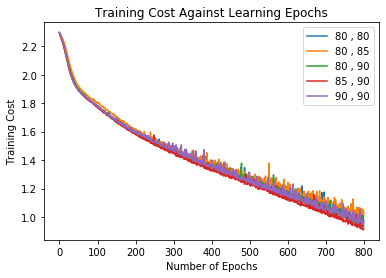

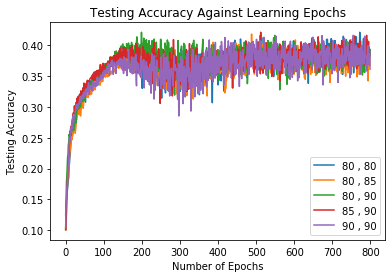

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

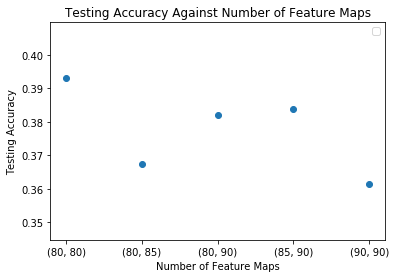

<Figure size 432x288 with 0 Axes>

In [0]:
hyper_parameter = [(80,80), (80,85), (80, 90), (85,90), (90,90)]
train_cost = []
test_acc = []
for h_para in hyper_parameter:
  train_result, test_result = train(h_para[0], h_para[1])
  train_cost.append(train_result)
  test_acc.append(test_result)

plt.figure(1)
for idx in range(len(train_cost)):
  plt.plot(range(epochs), train_cost[idx], label=str(hyper_parameter[idx][0])+" , " + str(hyper_parameter[idx][1]))
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Training Cost')
plt.title("Training Cost Against Learning Epochs")
plt.show()
plt.savefig('./2_train_cost_3-1.png')

plt.figure(1)
for idx in range(len(test_acc)):
  plt.plot(range(epochs), test_acc[idx], label=str(hyper_parameter[idx][0])+" , " + str(hyper_parameter[idx][1]))
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Learning Epochs")
plt.show()
plt.savefig('./2_test_acc_3-1.png')

plt.figure(2)

paras = [testing[-1] for testing in test_acc]

plt.scatter(range(len(hyper_parameter)), paras)
plt.xticks(range(len(hyper_parameter)), hyper_parameter)

plt.xlabel('Number of Feature Maps')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Number of Feature Maps")
plt.show()
plt.savefig('./2_test_acc_3-2.png')